In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import (
    ExtraTreesClassifier,
    ExtraTreesRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.model_selection import learning_curve
from sklearn.multioutput import RegressorChain, ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier,
    ExtraTreeClassifier,
    ExtraTreeRegressor,
)
from data_manipulations import *

In [2]:
pip freeze | grep -e pathlib -e functools -e numpy -e pandas -e polars -e matplotlib -e sci -e arrow

arrow==1.3.0
jaraco.functools==4.0.2
matplotlib==3.10.1
matplotlib-inline==0.1.7
numpy==2.2.4
pandas==2.2.3
polars==1.25.2
pyarrow==19.0.1
scikit-learn==1.6.1
scipy==1.15.2
Note: you may need to restart the kernel to use updated packages.


# Read data

In [3]:
train_features = pl.read_parquet('train_features.parquet')
train_targets = pl.read_parquet('train_targets.parquet')
test_features = pl.read_parquet('test_features.parquet')
test_targets = pl.read_parquet('test_targets.parquet')

data = prepare_data_for_ml(train_features, train_targets, test_features, test_targets)
data['train_features_rect'].shape, data['train_targets_rect'].shape

((1924, 100), (1924, 100))

In [4]:
# def restrict(frame, heads=(25, 20)):
#     keys = frame.columns[:2]
#     temp = join_many((
#         frame.select(keys[0]).unique().sort(by=keys[0]).head(heads[0]),
#         frame.select(keys[1]).unique().sort(by=keys[1]).head(heads[1]),
#     ), how='cross')
#     return frame.join(temp, on=keys)

# train_features = restrict(train_features)
# train_targets = restrict(train_targets)
# test_features = restrict(test_features)
# test_targets = restrict(test_targets)

# data = prepare_data_for_ml(train_features, train_targets, test_features, test_targets)
# data['train_features_rect'].shape, data['train_targets_rect'].shape

In [6]:
class ConvertTarget(BaseEstimator, ClassifierMixin):
    def __init__(self, clf_cls, **kwargs):
        self.clf_cls = clf_cls
        self.kwargs = kwargs
        self.model = clf_cls(**kwargs)

    def fit(self, train_features, train_targets):
        self.model.fit(train_features, ((train_targets + 1) // 2).astype(int))
        return self

    def predict(self, train_features):
        return self.model.predict(train_features) * 2 - 1

    @property
    def classes_(self):
        return self.model.classes_

# NaiveBayes

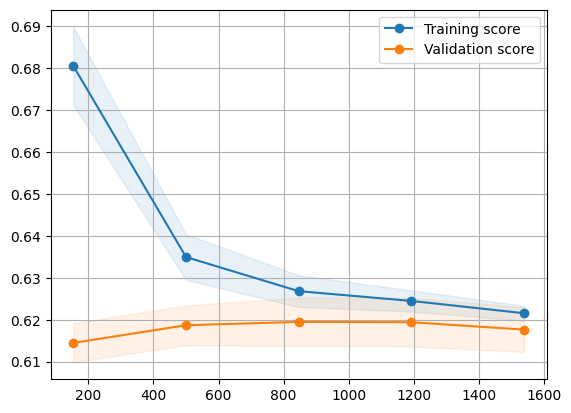

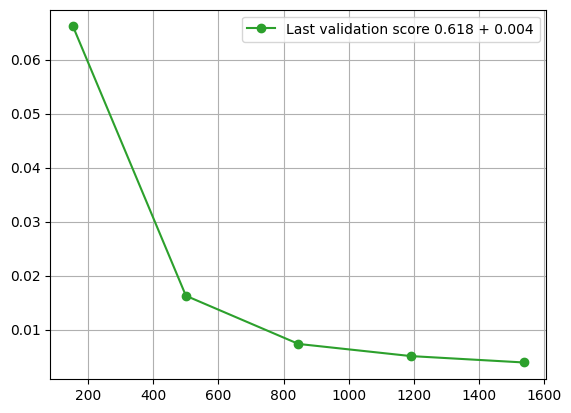

CPU times: user 295 ms, sys: 54.9 ms, total: 350 ms
Wall time: 11.7 s


In [9]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    ClassifierChain(ConvertTarget(GaussianNB), random_state=0),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].with_columns(pl.all().sign()).to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# Linear

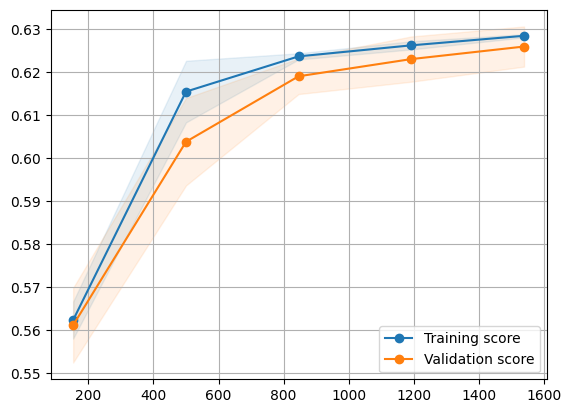

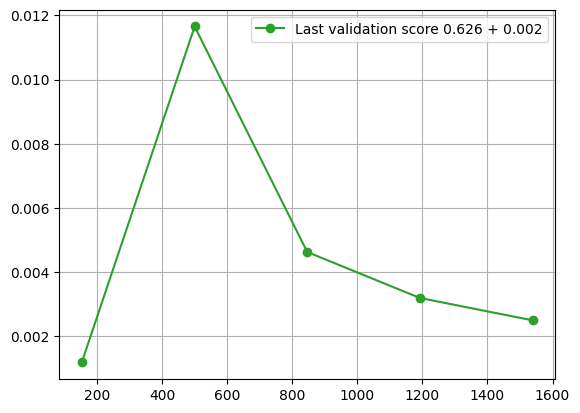

CPU times: user 252 ms, sys: 17.9 ms, total: 270 ms
Wall time: 6.85 s


In [10]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    ClassifierChain(ConvertTarget(LogisticRegression), random_state=0),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].with_columns(pl.all().sign()).to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

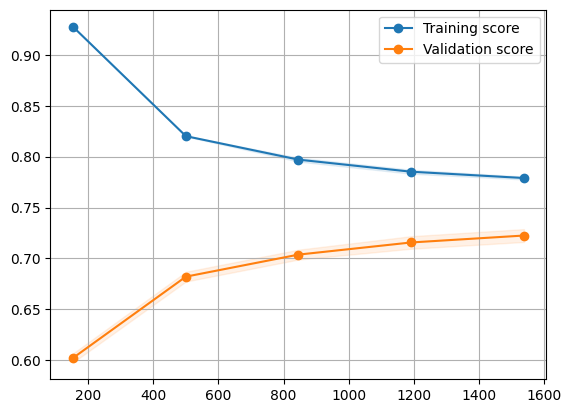

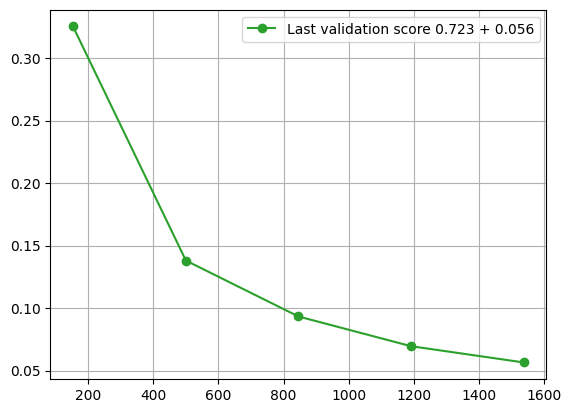

CPU times: user 199 ms, sys: 6.95 ms, total: 206 ms
Wall time: 391 ms


In [11]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

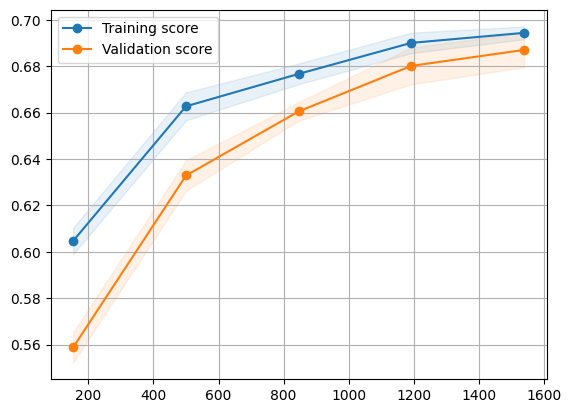

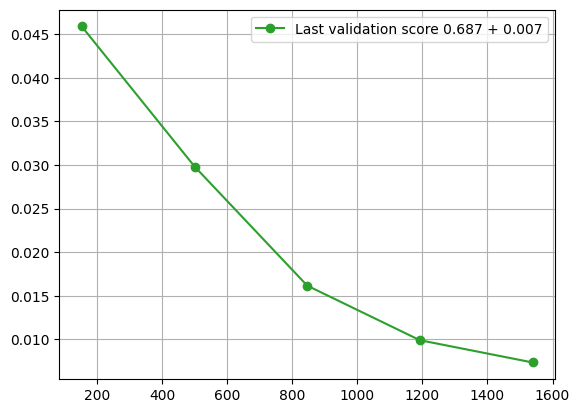

CPU times: user 204 ms, sys: 3.84 ms, total: 208 ms
Wall time: 2.64 s


In [12]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    RegressorChain(SGDRegressor(), random_state=0),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# SVM

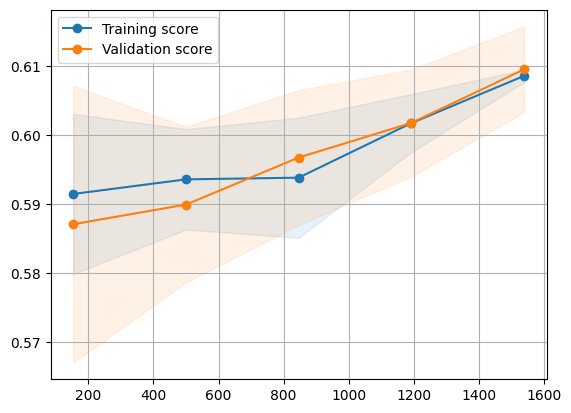

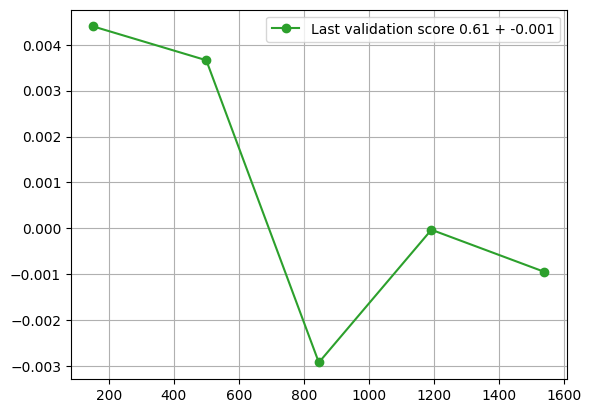

CPU times: user 506 ms, sys: 137 ms, total: 642 ms
Wall time: 2min 39s


In [13]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    ClassifierChain(ConvertTarget(SVC), random_state=0),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].with_columns(pl.all().sign()).to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

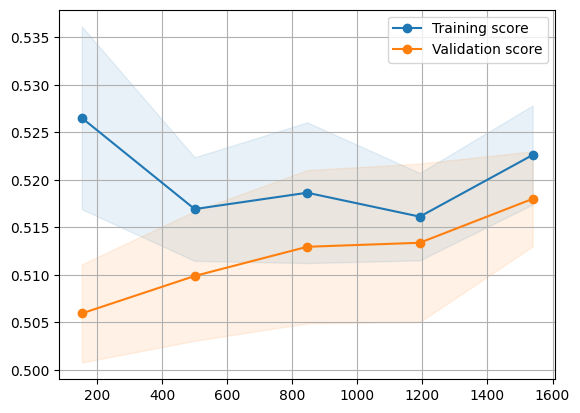

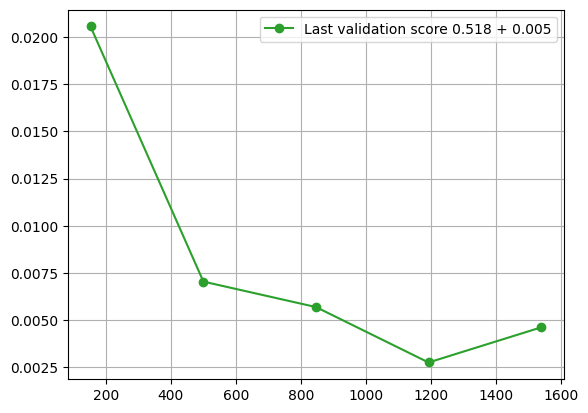

CPU times: user 248 ms, sys: 21.7 ms, total: 270 ms
Wall time: 3.93 s


In [14]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    RegressorChain(SVR(), random_state=0),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# DecisionTree

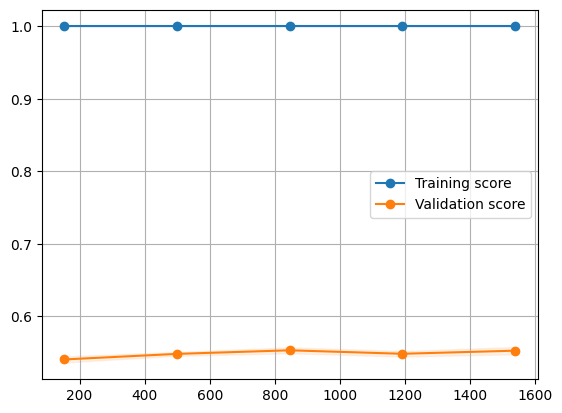

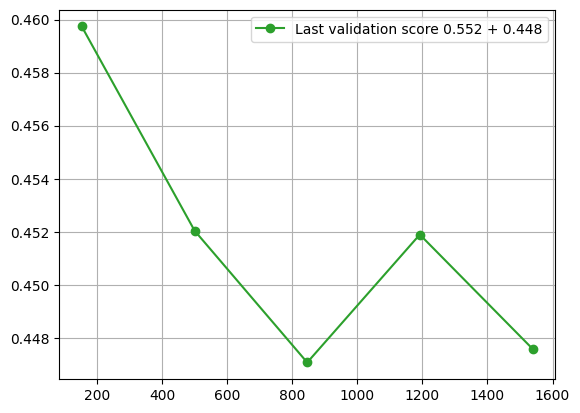

CPU times: user 203 ms, sys: 11.7 ms, total: 215 ms
Wall time: 3.05 s


In [15]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    ConvertTarget(DecisionTreeClassifier),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].with_columns(pl.all().sign()).to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

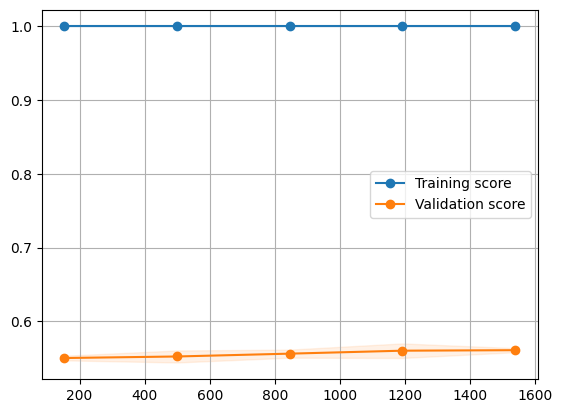

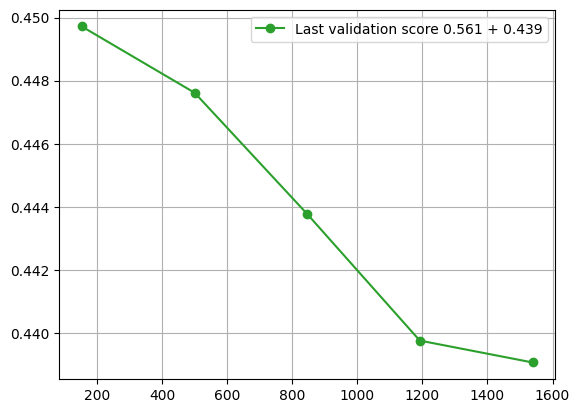

CPU times: user 162 ms, sys: 1.76 ms, total: 163 ms
Wall time: 1.26 s


In [16]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeRegressor(),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# ExtraTree

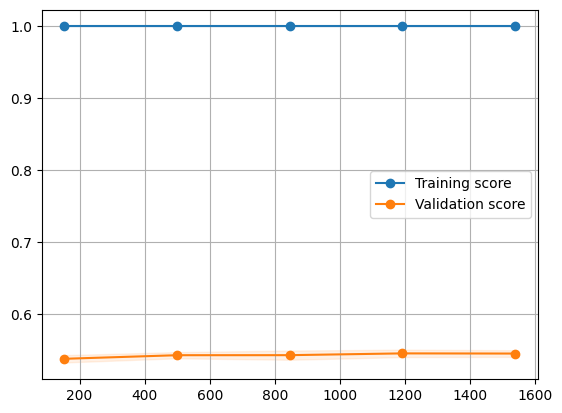

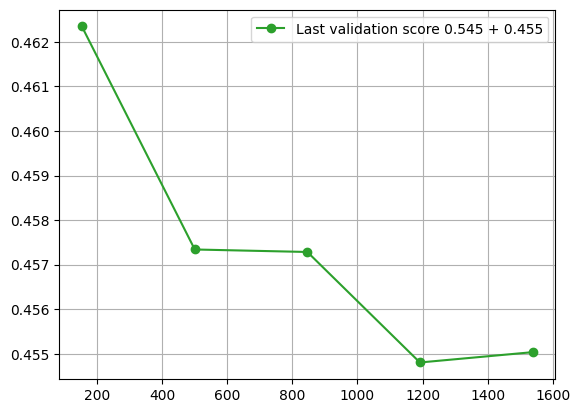

CPU times: user 210 ms, sys: 11.3 ms, total: 221 ms
Wall time: 437 ms


In [17]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    ConvertTarget(ExtraTreeClassifier),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].with_columns(pl.all().sign()).to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

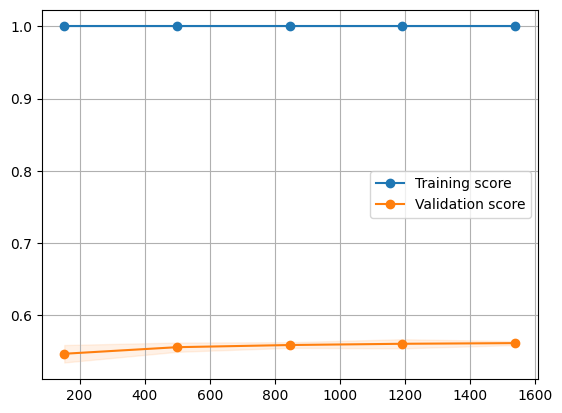

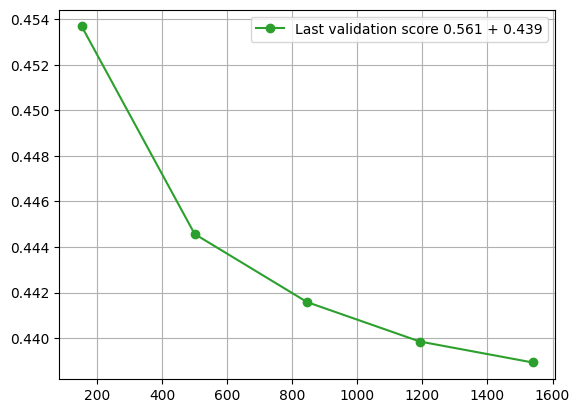

CPU times: user 194 ms, sys: 5.21 ms, total: 199 ms
Wall time: 432 ms


In [18]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    ExtraTreeRegressor(),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# ExtraTrees

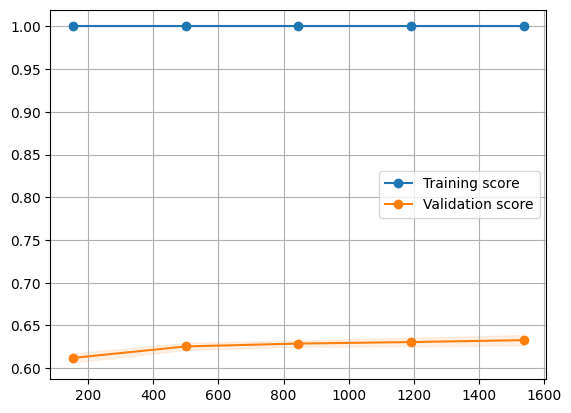

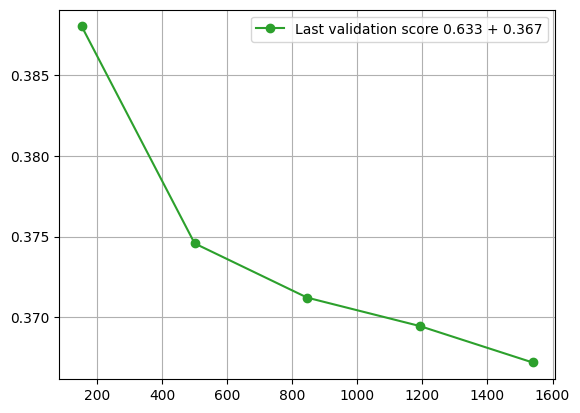

CPU times: user 195 ms, sys: 17.8 ms, total: 212 ms
Wall time: 9.73 s


In [19]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    ConvertTarget(ExtraTreesClassifier),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].with_columns(pl.all().sign()).to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

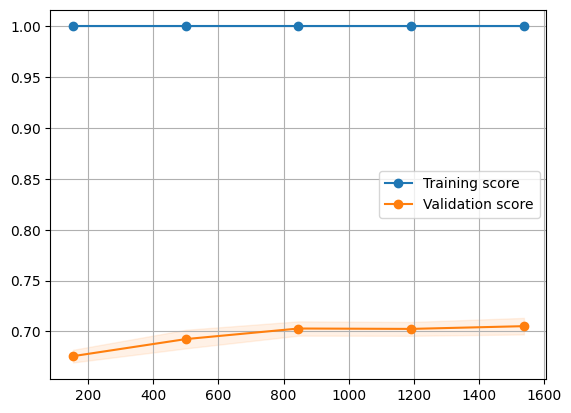

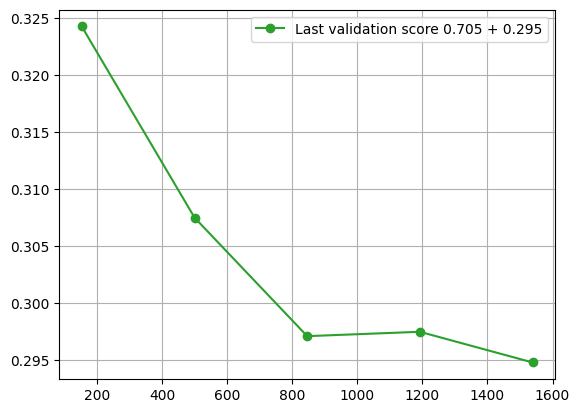

CPU times: user 191 ms, sys: 10.5 ms, total: 201 ms
Wall time: 14.4 s


In [20]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    ExtraTreesRegressor(),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# Random Forest

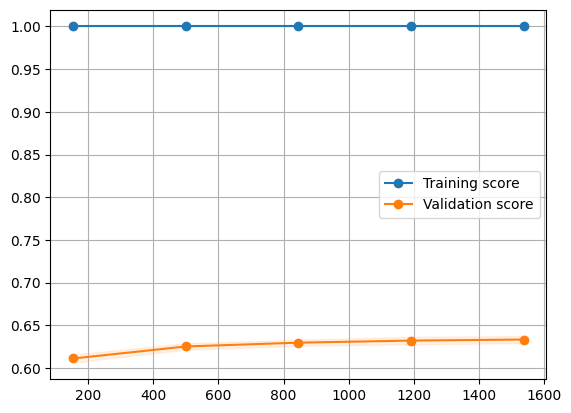

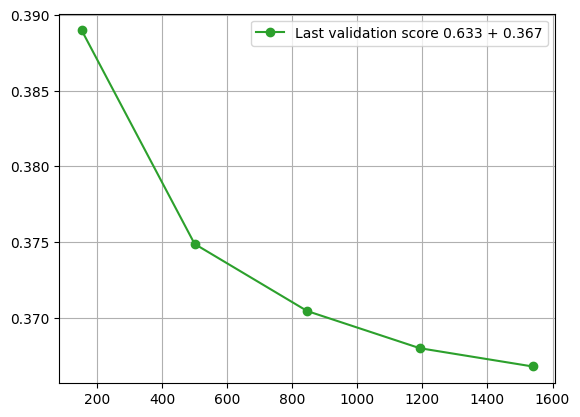

CPU times: user 227 ms, sys: 14.8 ms, total: 241 ms
Wall time: 23.1 s


In [21]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    ConvertTarget(RandomForestClassifier),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].with_columns(pl.all().sign()).to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

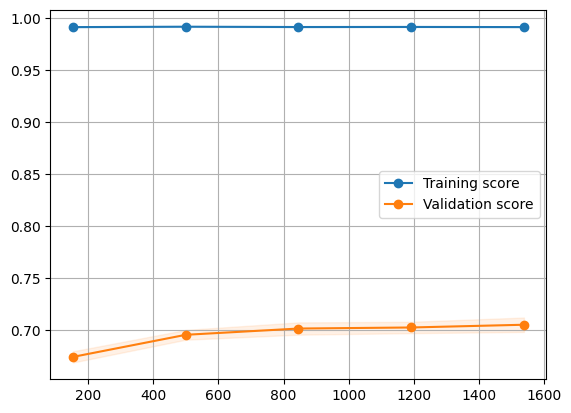

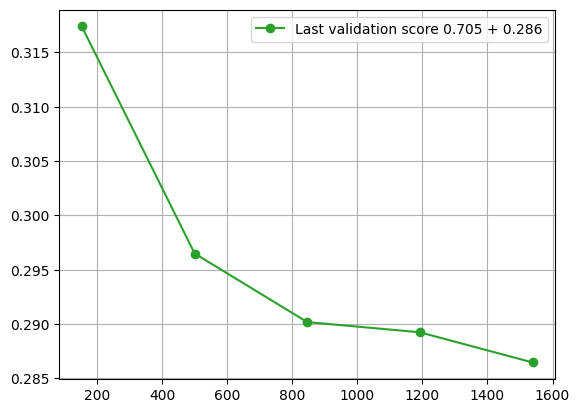

CPU times: user 222 ms, sys: 25.7 ms, total: 248 ms
Wall time: 1min 20s


In [22]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# HGB

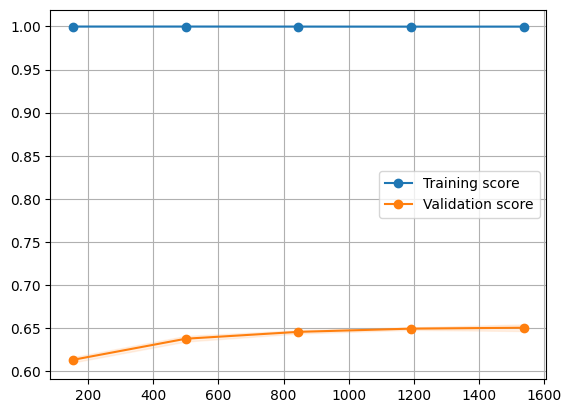

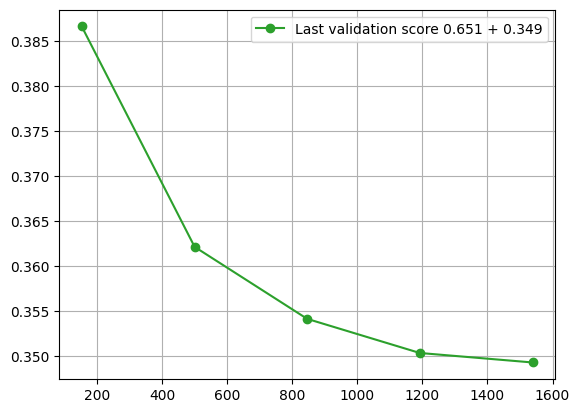

CPU times: user 6.36 s, sys: 1.62 s, total: 7.98 s
Wall time: 14min 55s


In [23]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    ClassifierChain(ConvertTarget(HistGradientBoostingClassifier), random_state=0),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].with_columns(pl.all().sign()).to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

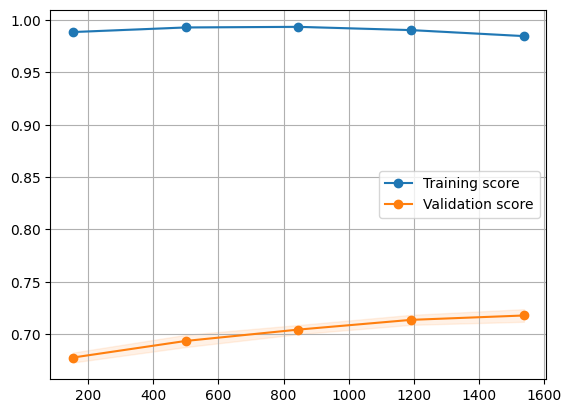

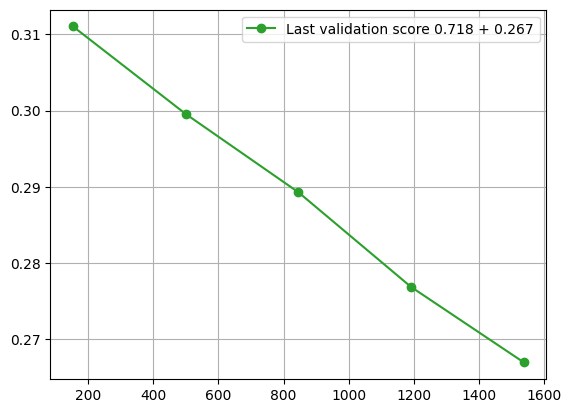

CPU times: user 6.19 s, sys: 1.73 s, total: 7.92 s
Wall time: 15min 52s


In [24]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    RegressorChain(HistGradientBoostingRegressor(), random_state=0),
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)